In [1]:
import numpy as np
import pandas as pd
import json
import pickle
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.patches as patches

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torch.utils.data

import matplotlib.pyplot as plt
import os

In [2]:
'''
Function that splits the data into a training, validation, and test set
'''
def split_data(dataset, train_split, seed):
    np.random.seed(seed)
    indices = list(range(len(dataset)))
    np.random.shuffle(indices)

    train_num = int(len(dataset)*train_split)
    val_num = (len(dataset) - int(len(dataset)*train_split))//2

    train_indices = indices[0:train_num]
    val_indices = indices[train_num:train_num+val_num]
    test_indices = indices[train_num+val_num:]

    #check to make sure slices correct
    assert len(dataset) == len(train_indices) + len(val_indices) + len(test_indices)

    #dataset = help.normalize(train_indices, dataset)

    train_data = dataset.iloc[train_indices,:]
    val_data = dataset.iloc[val_indices,:]
    test_data = dataset.iloc[test_indices,:]

    return train_data, val_data, test_data

data_df = pd.read_pickle('datasets/all_players_rel_all_actions_group_team_six_action_state.pkl')
train_data, val_data, test_data = split_data(data_df, 0.7, 2430)

In [3]:
'''
Loop to test model loss on held-out test data
'''
def test_loop(test_df, model, loss_fn, device):
    size = len(test_df)
    test_loss = 0
    
    with torch.no_grad():
        for row_index in range(0,len(test_df)):

            play = test_df.iloc[row_index, :]

            true_state = torch.tensor(play['state'], dtype=torch.float32).to(device=device)
            true_action = torch.tensor(play['action'], dtype=torch.float32).to(device=device)
            
            # useful for if testing in batches
            #true_state = torch.tensor(np.stack(play['state'].values), dtype=torch.float32).to(device=device)
            #true_action = torch.tensor(np.stack(play['action'].values), dtype=torch.float32).to(device=device)

            numpy_state_input = play['state'].reshape(1, 1, -1, action_size)
                           
            true_state_mod = torch.tensor(numpy_state_input, dtype=torch.float32).to(device=device)
            
            
            # do this because forget to replace nans in next state in dataset construction
            #next_state = torch.nan_to_num(next_state, nan=0)

            # Why does a state have nan values?
            #state = torch.nan_to_num(state, nan=0)

            model.eval()  # put model to eval mode

            #compute prediction and loss
            predicted_action = model(true_state_mod)
            
            true_action = torch.unsqueeze(true_action, 0)
            
            loss = loss_fn(predicted_action, true_action)
            
            test_loss += loss
        
        test_loss /= size

    
    return test_loss

In [4]:
'''
Creates matplot football viz
'''
def create_football_field(linenumbers=True,
                          endzones=True,
                          highlight_line=False,
                          highlight_line_number=50,
                          highlighted_name='Line of Scrimmage',
                          fifty_is_los=False,
                          figsize=(12, 6.33)):
    """
    Function that plots the football field for viewing plays.
    Allows for showing or hiding endzones.
    """
    rect = patches.Rectangle((0, 0), 120, 53.3, linewidth=0.1,
                             edgecolor='r', facecolor='darkgreen', zorder=0)

    fig, ax = plt.subplots(1, figsize=figsize)
    ax.add_patch(rect)

    plt.plot([10, 10, 10, 20, 20, 30, 30, 40, 40, 50, 50, 60, 60, 70, 70, 80,
              80, 90, 90, 100, 100, 110, 110, 120, 0, 0, 120, 120],
             [0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3,
              53.3, 0, 0, 53.3, 53.3, 0, 0, 53.3, 53.3, 53.3, 0, 0, 53.3],
             color='white')
    if fifty_is_los:
        plt.plot([60, 60], [0, 53.3], color='gold')
        plt.text(62, 50, '<- Player Yardline at Snap', color='gold')
    # Endzones
    if endzones:
        ez1 = patches.Rectangle((0, 0), 10, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ez2 = patches.Rectangle((110, 0), 120, 53.3,
                                linewidth=0.1,
                                edgecolor='r',
                                facecolor='blue',
                                alpha=0.2,
                                zorder=0)
        ax.add_patch(ez1)
        ax.add_patch(ez2)
    plt.xlim(0, 120)
    plt.ylim(-5, 58.3)
    plt.axis('off')
    if linenumbers:
        for x in range(20, 110, 10):
            numb = x
            if x > 50:
                numb = 120 - x
            plt.text(x, 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white')
            plt.text(x - 0.95, 53.3 - 5, str(numb - 10),
                     horizontalalignment='center',
                     fontsize=20,  # fontname='Arial',
                     color='white', rotation=180)
    if endzones:
        hash_range = range(11, 110)
    else:
        hash_range = range(1, 120)

    for x in hash_range:
        ax.plot([x, x], [0.4, 0.7], color='white')
        ax.plot([x, x], [53.0, 52.5], color='white')
        ax.plot([x, x], [22.91, 23.57], color='white')
        ax.plot([x, x], [29.73, 30.39], color='white')

    if highlight_line:
        hl = highlight_line_number + 10
        plt.plot([hl, hl], [0, 53.3], color='yellow')
        plt.text(hl + 2, 50, '<- {}'.format(highlighted_name),
                 color='yellow')
    return fig, ax

In [5]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print(device)

cuda


In [6]:
action_size = 6

cnn_model = nn.Sequential(
    nn.Conv2d(1, 12, (12,1), stride=1, padding=0),
    nn.LeakyReLU(),
    nn.Conv2d(12, 24, (6, 1)),
    nn.LeakyReLU(),
    nn.Conv2d(24, 48, (1,1)),
    nn.Flatten(),
    nn.Linear(48*7*6,action_size)
)

cnn_model.to(device=device)

Sequential(
  (0): Conv2d(1, 12, kernel_size=(12, 1), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(12, 24, kernel_size=(6, 1), stride=(1, 1))
  (3): LeakyReLU(negative_slope=0.01)
  (4): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=2016, out_features=6, bias=True)
)

In [7]:
cnn_model.load_state_dict(torch.load("saved_models/cnn_model_2.pt"))
cnn_model.eval()

Sequential(
  (0): Conv2d(1, 12, kernel_size=(12, 1), stride=(1, 1))
  (1): LeakyReLU(negative_slope=0.01)
  (2): Conv2d(12, 24, kernel_size=(6, 1), stride=(1, 1))
  (3): LeakyReLU(negative_slope=0.01)
  (4): Conv2d(24, 48, kernel_size=(1, 1), stride=(1, 1))
  (5): Flatten(start_dim=1, end_dim=-1)
  (6): Linear(in_features=2016, out_features=6, bias=True)
)

In [8]:
def compare_actions(df, row_index, cnn_model, verbose=False, save=False):
    
    play = df.iloc[row_index, :]

    numpy_state_input = play['state'].reshape(1, 1, -1, action_size)
    true_state_mod = torch.tensor(numpy_state_input, dtype=torch.float32).to(device=device)
    
    cnn_model.eval()
    next_action = cnn_model(true_state_mod).detach().cpu()
    
    print(f"next action: {next_action}")
    
    true_action = play['action']
    print(f"true action: {true_action}")

    fig, ax = plt.subplots()

    ax.scatter(true_action[0], true_action[1], c='red', s=50)
    ax.scatter(next_action[0,0], next_action[0,1], c='blue', s=50)
    ax.annotate('TRUE', (true_action[0], true_action[1]) )
    #ax.annotate('PREDICTED', (actor_next_action[0,0].detach().cpu(), actor_next_action[0,1].detach().cpu()))
    plt.title("True vs Predicted Action")
    plt.xlabel("X pos")
    plt.ylabel("Y pos")
    plt.xlim(-3,3)
    plt.ylim(-3,3)

    if save:
        plt.savefig("general_images/cnn2_prediction.png")
    plt.show()

In [ ]:
for row_index in range(10,20):
    compare_actions(test_data, row_index, cnn_model, verbose=False)

In [9]:
tracking2018 = pd.read_csv("csv/tracking2018.csv")
tracking2019 = pd.read_csv("csv/tracking2019.csv")
tracking2020 = pd.read_csv("csv/tracking2020.csv")

current state: x=75.6500015258789, y=45.29999923706055
true next state: x=75.17, y=45.98
predicted next state: x=75.98371124267578, y=45.10009002685547


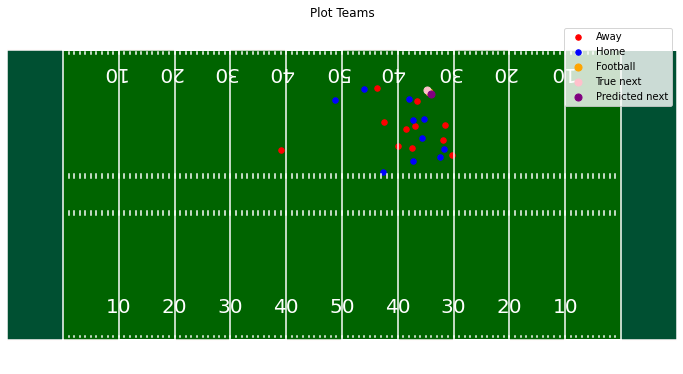

/tmp/ipykernel_1944/2526994725.py:72: MatplotlibDeprecationWarning: 
The zoom function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax2.xaxis.zoom(3)
/tmp/ipykernel_1944/2526994725.py:73: MatplotlibDeprecationWarning: 
The zoom function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  ax2.yaxis.zoom(1)


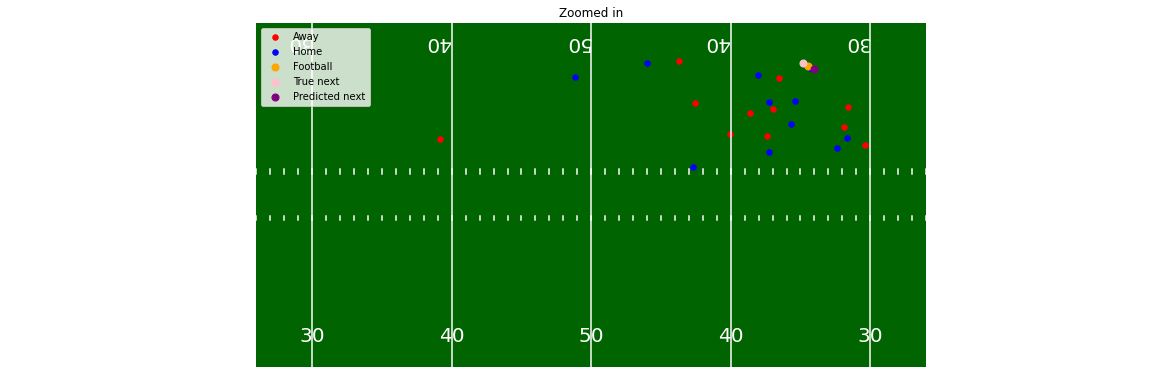

In [22]:
'''
Vizualize an entry and actions
'''

test_data_entry = test_data.iloc[1, :]


season = test_data_entry['season']
playId = test_data_entry['playId']
gameId = test_data_entry['gameId']
timeIndex = test_data_entry['timeIndex']

# get DF of entire play (includes all timesteps of play)
if season == '2019':
    play_df = tracking2019.query('playId == @playId and gameId == @gameId', inplace=False)
elif season == '2018':
    play_df = tracking2018.query('playId == @playId and gameId == @gameId', inplace=False)
elif season == '2020':
    play_df = tracking2020.query('playId == @playId and gameId == @gameId', inplace=False)
else:
    print('could not find')


# isolate specific time step we are looking at with ENTRY (from csv data)
all_time_steps = play_df.loc[:,'time'].unique()
time = all_time_steps[timeIndex]
entry = play_df.query('time == @time')
 
# calculate needed states from test data
true_state = torch.tensor(test_data_entry['state'], dtype=torch.float32)
true_action = torch.tensor(test_data_entry['action'], dtype=torch.float32)
numpy_state_input = test_data_entry['state'].reshape(1, 1, -1, action_size)
next_x = test_data_entry['next_state'][0]
next_y = test_data_entry['next_state'][1]

# get model output
true_state_mod = torch.tensor(numpy_state_input, dtype=torch.float32).to(device=device)
cnn_model.eval()
next_action = cnn_model(true_state_mod).detach().cpu()

predicted_x = true_state[0] + next_action[0][0]
predicted_y = true_state[1] + next_action[0][1]

print(f"current state: x={true_state[0]}, y={true_state[1]}")
print(f"true next state: x={next_x}, y={next_y}")
print(f"predicted next state: x={predicted_x}, y={predicted_y}")


d = {'new_x': [next_x], 'new_y': [next_y]}
new_pd_df = pd.DataFrame(data=d)

pred_d = {'predicted_x': [predicted_x], 'predicted_y': [predicted_y]}
pred_df = pd.DataFrame(data=pred_d)

fig, ax = create_football_field()

entry.query("team == 'away'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='red', s=30, label='Away')
entry.query("team == 'home'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='blue', s=30, label='Home')
entry.query("displayName == 'football'") \
    .plot(x='x', y='y', kind='scatter', ax=ax, color='orange', s=50, label='Football')
new_pd_df.plot(x='new_x', y='new_y', kind='scatter', ax=ax, color='pink', s=50, label='True next')
pred_df.plot(x='predicted_x', y='predicted_y', kind='scatter', ax=ax, color='purple', s=50, label='Predicted next')
plt.title('Plot Teams')
plt.show()

#fig, ax = plt.subplots(1, figsize=12, 6.33)

fig2, ax2 = create_football_field()
#fig2.set_size_inches(18.5, 10.5)
ax2.xaxis.zoom(3)
ax2.yaxis.zoom(1)
#buffer=3
#ax2.set_xlim(next_x-buffer, next_x+buffer)
#plt.xlim(next_x-buffer, next_x+buffer)

entry.query("team == 'away'") \
    .plot(x='x', y='y', kind='scatter', ax=ax2, color='red', s=30, label='Away')
entry.query("team == 'home'") \
    .plot(x='x', y='y', kind='scatter', ax=ax2, color='blue', s=30, label='Home')
entry.query("displayName == 'football'") \
    .plot(x='x', y='y', kind='scatter', ax=ax2, color='orange', s=50, label='Football')
new_pd_df.plot(x='new_x', y='new_y', kind='scatter', ax=ax2, color='pink', s=50, label='True next')
pred_df.plot(x='predicted_x', y='predicted_y', kind='scatter', ax=ax2, color='purple', s=50, label='Predicted next')
plt.title('Zoomed in')
#buffer=3
#plt.xlim(next_x-buffer, next_x+buffer)
#plt.ylim(next_y-buffer, next_y+buffer)
    
plt.legend()
plt.show()
